In [1]:
from graphviz import Digraph
import math
import numpy as np
import random

In [15]:
class Track():
    def __init__(self, data, prev=(), op='', label=""):
        self.data = data
        self.grad = 0
        self.prev = prev
        self.op   = op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"(data: {self.data}, grad: {self.grad})" 
    
    def __add__(self, other):
        other = other if isinstance(other, Track) else Track(other)
        output = Track(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad  += output.grad 
            other.grad += output.grad 
        output._backward = _backward
        return output
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other): 
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Track) else Track(other)
        output = Track(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad  += other.data * output.grad
            other.grad += self.data  * output.grad
        output._backward = _backward  
        return output
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        output = Track(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * output.grad
        output._backward = _backward
        return output
    
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self):
        return self * -1
    
    def tanh(self):
        output = Track((math.exp(self.data * 2) - 1) / (math.exp(self.data * 2) + 1), (self,), "tanh")
        
        def _backward():
            self.grad += (1 - output.data**2) * output.grad
        output._backward = _backward
        return output
    
    def relu(self):
        output = Track(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (output.data > 0) * output.grad
        output._backward = _backward
        return output
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        
    
    def trace(self, root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
        build(root)
        return nodes, edges

    def draw_dot(self, format='svg', rankdir='LR'):
        """
        format: png | svg | ...
        rankdir: TB (top to bottom graph) | LR (left to right)
        """
        assert rankdir in ['LR', 'TB']
        nodes, edges = self.trace(self)
        dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

        for n in nodes:
            dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label ,n.data, n.grad), shape='record')
            if n.op:
                dot.node(name=str(id(n)) + n.op, label=n.op)
                dot.edge(str(id(n)) + n.op, str(id(n)))

        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2.op)

        return dot
   

class Neuron():
    
    def __init__(self, nin):
        self.w = [Track(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Track(random.uniform(-1,1), label="b")
        
    def __call__(self, x, acf="tanh"):
        assert acf in ["ReLU", "tanh"]
        
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if(acf == "ReLU"):
            return act.relu() if self.nonlin else act
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer():

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP():

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

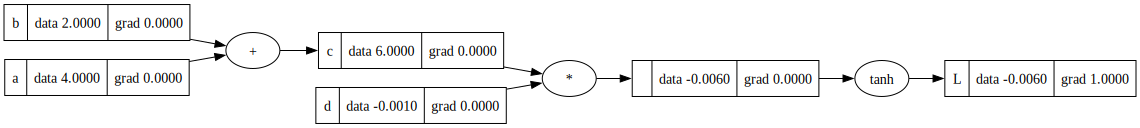

In [3]:
a = Track(4, label="a")
b = Track(2, label="b")
c = a + b ; c.label="c"
d = Track(-0.001, label="d")
e = c * d
L = e.tanh(); L.label="L"; L.grad = 1;
L.draw_dot()

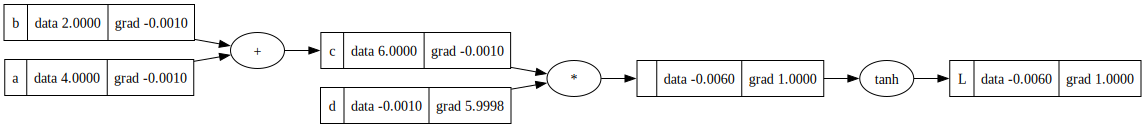

In [4]:
L.backward()
L.draw_dot()

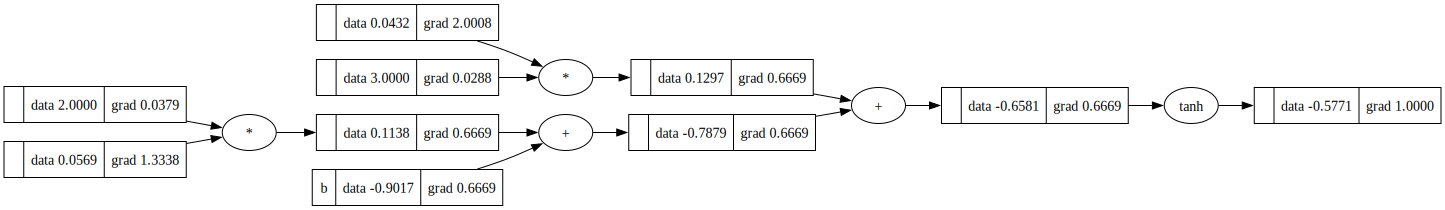

In [26]:
x = [2.0, 3.0]
n = Neuron(2)
m = n(x)
m.backward()
m.draw_dot()

In [31]:
x = [2.0, 3.0]
l = Layer(2, 1)
l(x)

(data: 0.8265219478381658, grad: 0)

In [5]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

(data: -0.37335496403749807, grad: 0)

In [6]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[(data: -0.37335496403749807, grad: 0),
 (data: 0.32931222290088236, grad: 0),
 (data: -0.07473230531776559, grad: 0),
 (data: 0.8799812438743119, grad: 0)]

In [7]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

(data: 4.523699651844657, grad: 0)

In [8]:
for k in range(10):
    # forward pass
    ypred = [n(x) for x in xs] 
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)


0 4.523699651844657
1 2.901622085350671
2 2.3114674352560276
3 1.3754562858698973
4 0.6800472002680893
5 0.3870524303861611
6 0.25338165301646187
7 0.18480383958605867
8 0.14369441906437472
9 0.1166160342177828


In [9]:
ypred

[(data: 0.782111486773747, grad: -0.43577702645250604),
 (data: -0.8850499384557914, grad: 0.22990012308841723),
 (data: -0.7644038262725937, grad: 0.47119234745481253),
 (data: 0.9794681637980374, grad: -0.04106367240392528)]

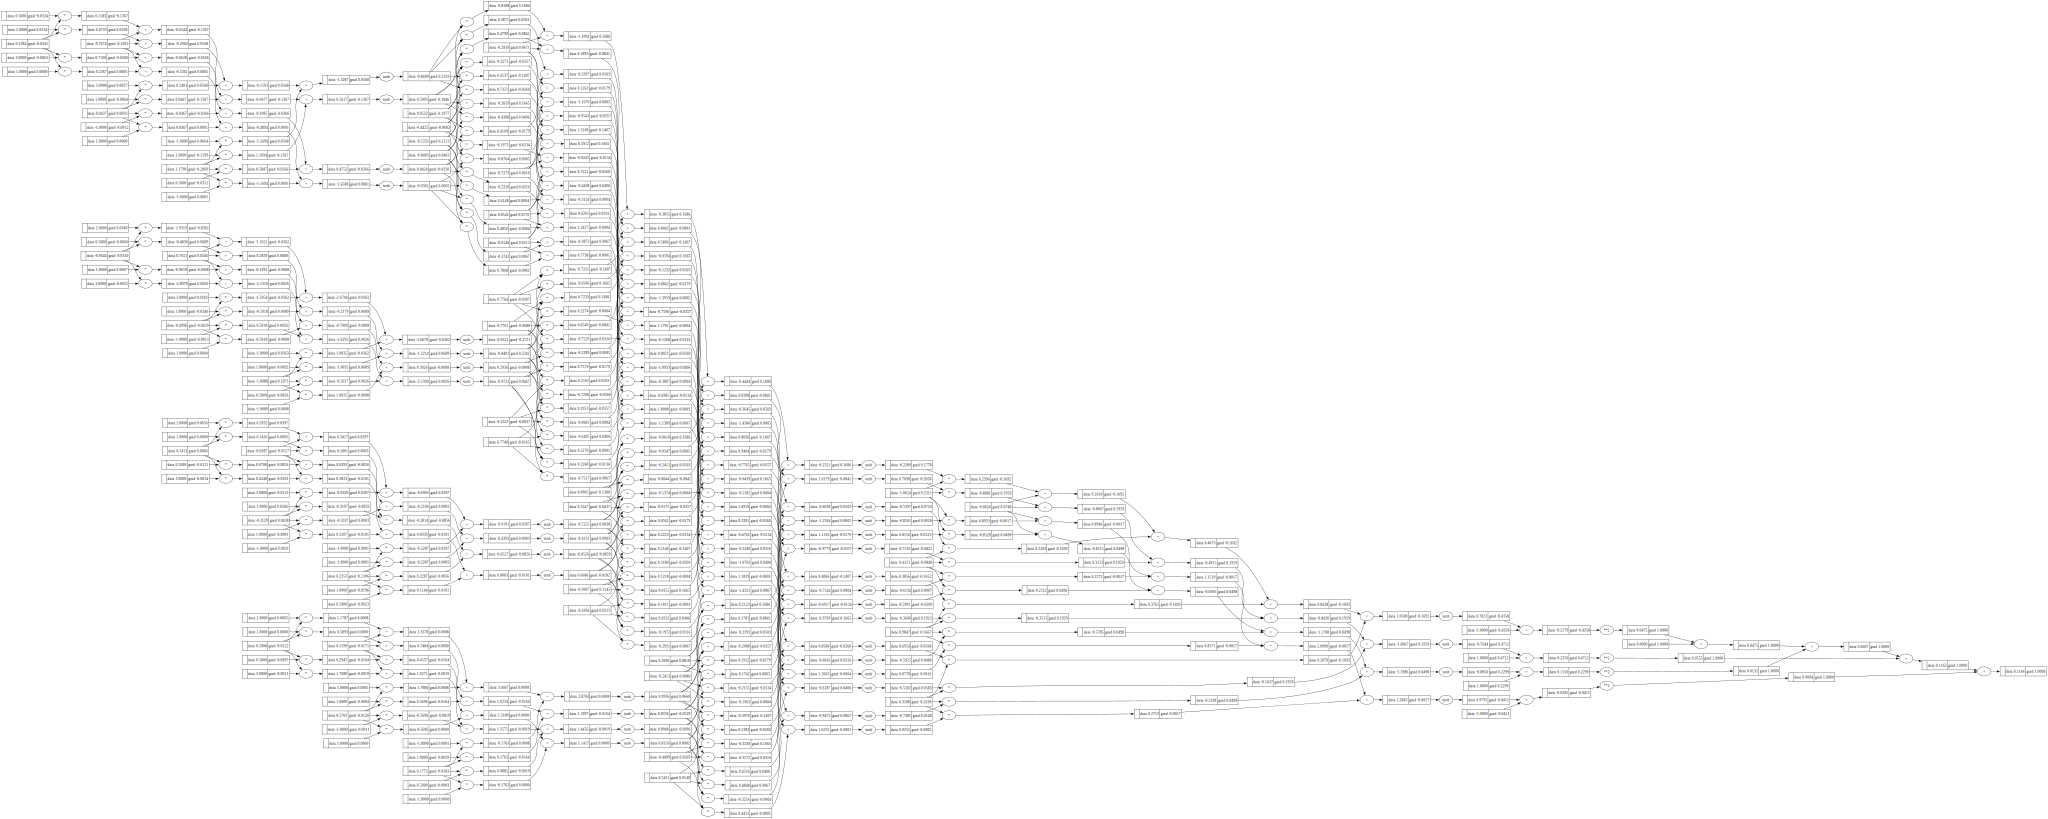

In [10]:
loss.draw_dot()